# Frequency Analysis

This notebook provides detailed analysis of the frequency structure in compressed modular addition models:
- Validation accuracy curve
- Interaction matrix visualization
- Eigendecomposition analysis (effective rank, explained variance)
- FFT analysis of eigenvectors
- Frequency heatmaps per bottleneck size

In [1]:
import sys
import os
from pathlib import Path

# Add project root to path for imports
try:
    _this_file = Path(__file__).resolve()
    project_root = _this_file.parent.parent.parent.parent
except NameError:
    # Running in notebook - find project root from cwd
    cwd = Path.cwd()
    if (cwd / 'modular_addition').exists():
        project_root = cwd
    else:
        project_root = cwd.parent.parent.parent
        if not (project_root / 'modular_addition').exists():
            project_root = cwd

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm

from modular_addition.core import load_sweep_results, get_device
from modular_addition.compression.js_div import (
    compute_interaction_matrices,
    compute_eigen_data,
    compute_frequency_heatmap,
    analyze_eigenvector_fft,
    entropy_effective_rank,
    ratio_effective_rank,
    cumulative_explained_variance,
    components_for_variance_threshold
)

# Configuration
SWEEP_PATH = project_root / 'modular_addition' / 'compression' / 'comp_diagrams' / 'sweep_results_0401.pkl'
DEVICE = get_device()
print(f'Device: {DEVICE}')
print(f'Sweep path: {SWEEP_PATH}')

Device: cpu
Sweep path: /home/martin-lanigo/tn_4_interp/modular_addition/compression/comp_diagrams/sweep_results_0401.pkl


## Load Data

In [2]:
# Load sweep results
models_state, val_acc, P = load_sweep_results(SWEEP_PATH)
print(f'Loaded {len(models_state)} models with P={P}')
print(f'Validation accuracies available: {len(val_acc)}')

Loaded 64 models with P=64
Validation accuracies available: 64


## Validation Accuracy Curve

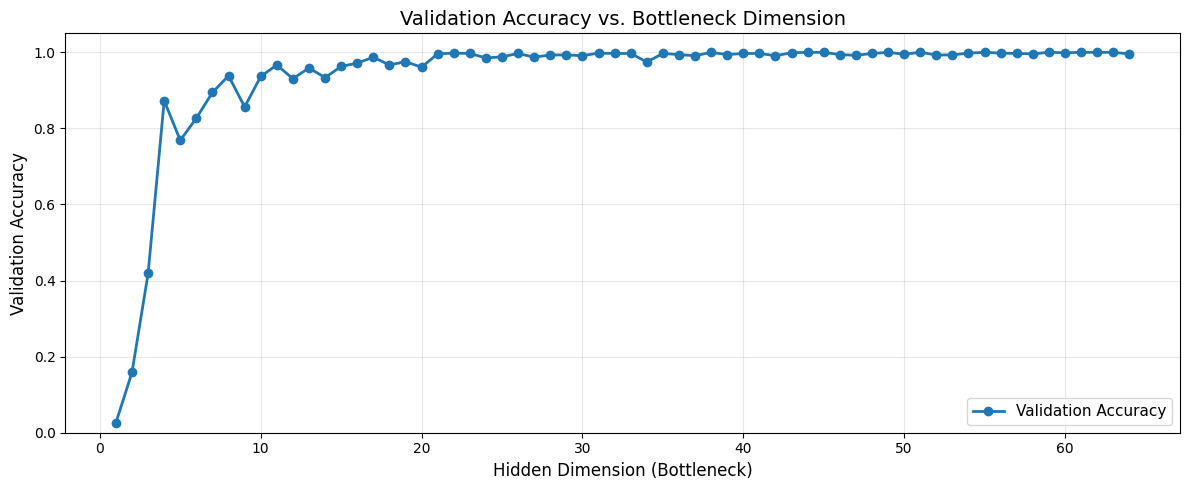

Smallest dimension with perfect accuracy: 38
Smallest dimension with >95% accuracy: 11


In [3]:
if len(val_acc) > 0:
    dims_sorted = sorted(list(val_acc.keys()), reverse=True)
    accs_sorted = [val_acc[d] for d in dims_sorted]
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(dims_sorted, accs_sorted, 'o-', linewidth=2, markersize=6, label='Validation Accuracy')
    ax.set_xlabel('Hidden Dimension (Bottleneck)', fontsize=12)
    ax.set_ylabel('Validation Accuracy', fontsize=12)
    ax.set_title('Validation Accuracy vs. Bottleneck Dimension', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    ax.set_ylim([0, 1.05])
    plt.tight_layout()
    plt.show()
    
    # Find threshold dimensions
    perfect_dims = [d for d, acc in val_acc.items() if acc >= 0.999]
    if perfect_dims:
        print(f'Smallest dimension with perfect accuracy: {min(perfect_dims)}')
    high_acc_dims = [d for d, acc in val_acc.items() if acc >= 0.95]
    if high_acc_dims:
        print(f'Smallest dimension with >95% accuracy: {min(high_acc_dims)}')
else:
    print('No validation accuracies available.')

## Compute Interaction Matrices and Eigendecomposition

In [4]:
# Compute interaction matrices
print('Computing interaction matrices...')
int_mats = compute_interaction_matrices(models_state, P, DEVICE)
print(f'Computed interaction matrices for {len(int_mats)} models')

# Compute eigendecomposition
print('\nComputing eigendecomposition...')
eigen_data = compute_eigen_data(int_mats, P)
print(f'Computed eigendecomposition for {len(eigen_data)} models')

Computing interaction matrices...


Computing interaction matrices:   0%|          | 0/64 [00:00<?, ?it/s]

Computing interaction matrices:   2%|▏         | 1/64 [00:01<01:38,  1.56s/it]

Computing interaction matrices:  25%|██▌       | 16/64 [00:01<00:03, 13.11it/s]

Computing interaction matrices:  52%|█████▏    | 33/64 [00:01<00:01, 29.76it/s]

Computing interaction matrices:  80%|███████▉  | 51/64 [00:01<00:00, 49.24it/s]

Computing interaction matrices: 100%|██████████| 64/64 [00:01<00:00, 32.92it/s]

Computed interaction matrices for 64 models

Computing eigendecomposition...


Computing eigendecomposition:   0%|          | 0/64 [00:00<?, ?it/s]

Computing eigendecomposition:   2%|▏         | 1/64 [00:00<00:25,  2.51it/s]

Computing eigendecomposition:   3%|▎         | 2/64 [00:00<00:23,  2.63it/s]

Computing eigendecomposition:   5%|▍         | 3/64 [00:01<00:22,  2.68it/s]

Computing eigendecomposition:   6%|▋         | 4/64 [00:01<00:21,  2.76it/s]

Computing eigendecomposition:   8%|▊         | 5/64 [00:01<00:19,  3.09it/s]

Computing eigendecomposition:   9%|▉         | 6/64 [00:02<00:20,  2.81it/s]

Computing eigendecomposition:  11%|█         | 7/64 [00:02<00:19,  2.92it/s]

Computing eigendecomposition:  12%|█▎        | 8/64 [00:02<00:18,  3.04it/s]

Computing eigendecomposition:  14%|█▍        | 9/64 [00:03<00:18,  2.92it/s]

Computing eigendecomposition:  16%|█▌        | 10/64 [00:03<00:18,  2.93it/s]

Computing eigendecomposition:  17%|█▋        | 11/64 [00:03<00:17,  3.07it/s]

Computing eigendecomposition:  19%|█▉        | 12/64 [00:04<00:15,  3.27it/s]

Computing eigendecomposition:  20%|██        | 13/64 [00:04<00:15,  3.28it/s]

Computing eigendecomposition:  22%|██▏       | 14/64 [00:04<00:15,  3.28it/s]

Computing eigendecomposition:  23%|██▎       | 15/64 [00:04<00:14,  3.32it/s]

Computing eigendecomposition:  25%|██▌       | 16/64 [00:05<00:15,  3.19it/s]

Computing eigendecomposition:  27%|██▋       | 17/64 [00:05<00:14,  3.18it/s]

Computing eigendecomposition:  28%|██▊       | 18/64 [00:05<00:14,  3.08it/s]

Computing eigendecomposition:  30%|██▉       | 19/64 [00:06<00:13,  3.22it/s]

Computing eigendecomposition:  31%|███▏      | 20/64 [00:06<00:16,  2.71it/s]

Computing eigendecomposition:  33%|███▎      | 21/64 [00:07<00:15,  2.75it/s]

Computing eigendecomposition:  34%|███▍      | 22/64 [00:07<00:15,  2.73it/s]

Computing eigendecomposition:  36%|███▌      | 23/64 [00:07<00:14,  2.87it/s]

Computing eigendecomposition:  38%|███▊      | 24/64 [00:08<00:12,  3.13it/s]

Computing eigendecomposition:  39%|███▉      | 25/64 [00:08<00:14,  2.73it/s]

Computing eigendecomposition:  41%|████      | 26/64 [00:08<00:14,  2.70it/s]

Computing eigendecomposition:  42%|████▏     | 27/64 [00:09<00:13,  2.79it/s]

Computing eigendecomposition:  44%|████▍     | 28/64 [00:09<00:13,  2.70it/s]

Computing eigendecomposition:  45%|████▌     | 29/64 [00:09<00:12,  2.84it/s]

Computing eigendecomposition:  47%|████▋     | 30/64 [00:10<00:11,  2.97it/s]

Computing eigendecomposition:  48%|████▊     | 31/64 [00:10<00:12,  2.73it/s]

Computing eigendecomposition:  50%|█████     | 32/64 [00:10<00:11,  2.90it/s]

Computing eigendecomposition:  52%|█████▏    | 33/64 [00:11<00:10,  2.88it/s]

Computing eigendecomposition:  53%|█████▎    | 34/64 [00:11<00:11,  2.53it/s]

Computing eigendecomposition:  55%|█████▍    | 35/64 [00:12<00:12,  2.27it/s]

Computing eigendecomposition:  56%|█████▋    | 36/64 [00:12<00:13,  2.01it/s]

Computing eigendecomposition:  58%|█████▊    | 37/64 [00:13<00:13,  1.98it/s]

Computing eigendecomposition:  59%|█████▉    | 38/64 [00:13<00:13,  1.98it/s]

Computing eigendecomposition:  61%|██████    | 39/64 [00:14<00:12,  1.98it/s]

Computing eigendecomposition:  62%|██████▎   | 40/64 [00:14<00:12,  1.98it/s]

Computing eigendecomposition:  64%|██████▍   | 41/64 [00:15<00:12,  1.82it/s]

Computing eigendecomposition:  66%|██████▌   | 42/64 [00:16<00:11,  1.91it/s]

Computing eigendecomposition:  67%|██████▋   | 43/64 [00:16<00:10,  1.92it/s]

Computing eigendecomposition:  69%|██████▉   | 44/64 [00:17<00:11,  1.71it/s]

Computing eigendecomposition:  70%|███████   | 45/64 [00:17<00:10,  1.81it/s]

Computing eigendecomposition:  72%|███████▏  | 46/64 [00:18<00:09,  1.89it/s]

Computing eigendecomposition:  73%|███████▎  | 47/64 [00:18<00:08,  1.91it/s]

Computing eigendecomposition:  75%|███████▌  | 48/64 [00:19<00:08,  1.94it/s]

Computing eigendecomposition:  77%|███████▋  | 49/64 [00:19<00:07,  2.09it/s]

Computing eigendecomposition:  78%|███████▊  | 50/64 [00:20<00:06,  2.11it/s]

Computing eigendecomposition:  80%|███████▉  | 51/64 [00:20<00:06,  2.07it/s]

Computing eigendecomposition:  81%|████████▏ | 52/64 [00:21<00:06,  1.98it/s]

Computing eigendecomposition:  83%|████████▎ | 53/64 [00:21<00:05,  2.01it/s]

Computing eigendecomposition:  84%|████████▍ | 54/64 [00:22<00:05,  1.77it/s]

Computing eigendecomposition:  86%|████████▌ | 55/64 [00:23<00:05,  1.73it/s]

Computing eigendecomposition:  88%|████████▊ | 56/64 [00:23<00:04,  1.72it/s]

Computing eigendecomposition:  89%|████████▉ | 57/64 [00:24<00:03,  1.81it/s]

Computing eigendecomposition:  91%|█████████ | 58/64 [00:24<00:03,  1.79it/s]

Computing eigendecomposition:  92%|█████████▏| 59/64 [00:25<00:02,  1.89it/s]

Computing eigendecomposition:  94%|█████████▍| 60/64 [00:25<00:02,  1.92it/s]

Computing eigendecomposition:  95%|█████████▌| 61/64 [00:26<00:01,  1.87it/s]

Computing eigendecomposition:  97%|█████████▋| 62/64 [00:26<00:01,  1.90it/s]

Computing eigendecomposition:  98%|█████████▊| 63/64 [00:27<00:00,  1.75it/s]

Computing eigendecomposition: 100%|██████████| 64/64 [00:27<00:00,  1.79it/s]

Computing eigendecomposition: 100%|██████████| 64/64 [00:27<00:00,  2.29it/s]

Computed eigendecomposition for 64 models


## Interaction Matrix Visualization

In [5]:
def show_interaction_matrix(d_hidden=P, remainder=0):
    """Visualize interaction matrix for a given bottleneck size and remainder."""
    mat = int_mats[d_hidden][remainder]
    
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(mat, cmap='RdBu', aspect='auto', origin='lower')
    ax.set_xlabel('Input index')
    ax.set_ylabel('Input index')
    ax.set_title(f'Interaction Matrix: d_hidden={d_hidden}, remainder={remainder}')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Interactive exploration
d_slider = widgets.IntSlider(min=1, max=P, step=1, value=P, description='d_hidden')
r_slider = widgets.IntSlider(min=0, max=P-1, step=1, value=0, description='remainder')
out = widgets.interactive_output(show_interaction_matrix, {'d_hidden': d_slider, 'remainder': r_slider})
display(widgets.HBox([d_slider, r_slider]), out)

Output()

## Effective Rank Analysis

In [6]:
# Compute effective ranks for all models
entropy_ranks = {}
ratio_ranks = {}

for d_hidden in range(1, P+1):
    evals = eigen_data[d_hidden]['eigenvalues']  # (P, 2P)
    
    entropy_per_remainder = [entropy_effective_rank(evals[r]) for r in range(P)]
    ratio_per_remainder = [ratio_effective_rank(evals[r]) for r in range(P)]
    
    entropy_ranks[d_hidden] = {
        'mean': np.mean(entropy_per_remainder),
        'std': np.std(entropy_per_remainder),
        'per_remainder': entropy_per_remainder
    }
    ratio_ranks[d_hidden] = {
        'mean': np.mean(ratio_per_remainder),
        'std': np.std(ratio_per_remainder),
        'per_remainder': ratio_per_remainder
    }

print('Computed effective ranks for all models')

Computed effective ranks for all models


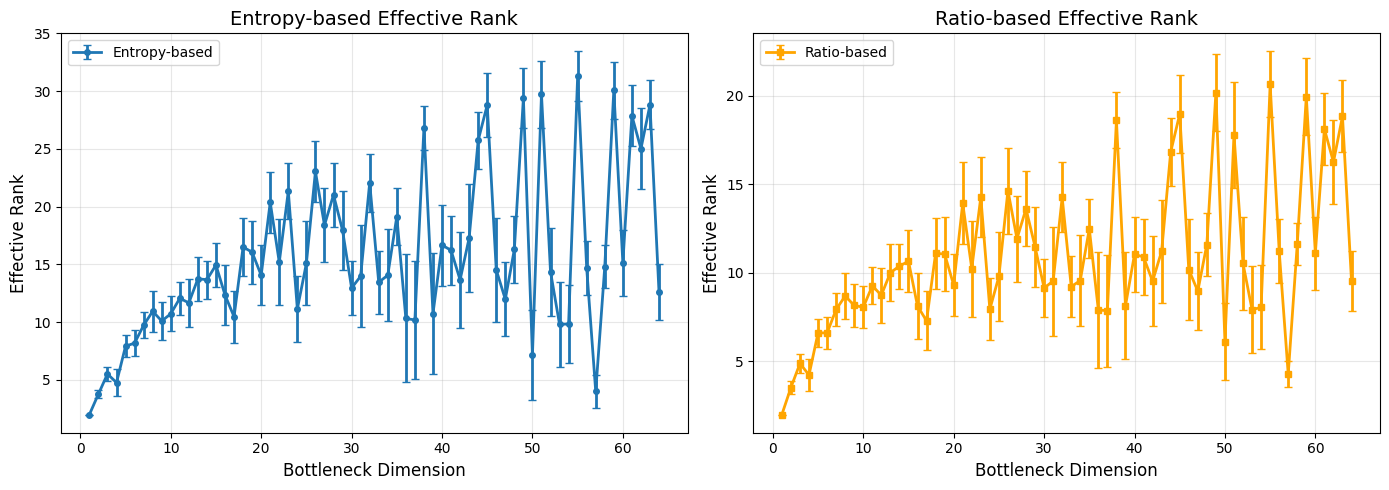

In [7]:
# Plot effective ranks vs bottleneck dimension
dims = list(range(1, P+1))
entropy_means = [entropy_ranks[d]['mean'] for d in dims]
entropy_stds = [entropy_ranks[d]['std'] for d in dims]
ratio_means = [ratio_ranks[d]['mean'] for d in dims]
ratio_stds = [ratio_ranks[d]['std'] for d in dims]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entropy-based effective rank
ax1 = axes[0]
ax1.errorbar(dims, entropy_means, yerr=entropy_stds, fmt='o-', capsize=3,
             linewidth=2, markersize=4, label='Entropy-based')
ax1.set_xlabel('Bottleneck Dimension', fontsize=12)
ax1.set_ylabel('Effective Rank', fontsize=12)
ax1.set_title('Entropy-based Effective Rank', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Ratio-based effective rank
ax2 = axes[1]
ax2.errorbar(dims, ratio_means, yerr=ratio_stds, fmt='s-', capsize=3,
             linewidth=2, markersize=4, color='orange', label='Ratio-based')
ax2.set_xlabel('Bottleneck Dimension', fontsize=12)
ax2.set_ylabel('Effective Rank', fontsize=12)
ax2.set_title('Ratio-based Effective Rank', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## Cumulative Explained Variance

In [8]:
# Compute for multiple thresholds
variance_thresholds = [0.90, 0.95, 0.99]
components_needed = {thresh: {} for thresh in variance_thresholds}

for d_hidden in range(1, P+1):
    evals = eigen_data[d_hidden]['eigenvalues']  # (P, 2P), already sorted by |λ|
    
    for thresh in variance_thresholds:
        comps_per_remainder = [components_for_variance_threshold(evals[r], thresh) for r in range(P)]
        components_needed[thresh][d_hidden] = {
            'mean': np.mean(comps_per_remainder),
            'std': np.std(comps_per_remainder),
            'max': np.max(comps_per_remainder),
            'per_remainder': comps_per_remainder
        }

print(f'Computed components needed for variance thresholds: {variance_thresholds}')

Computed components needed for variance thresholds: [0.9, 0.95, 0.99]


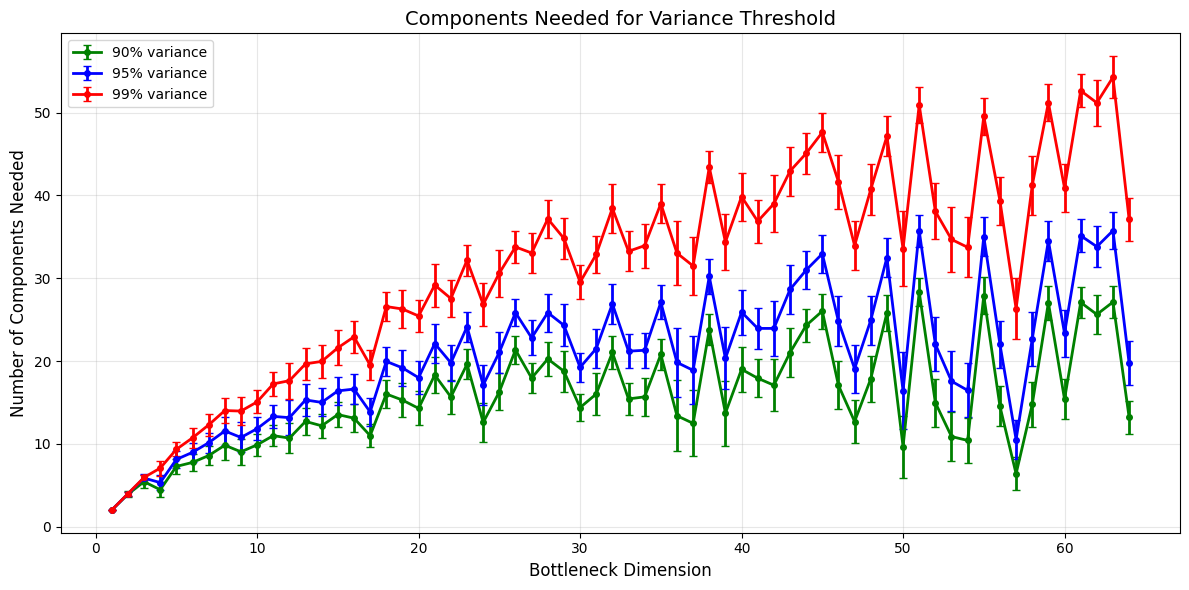

In [9]:
# Plot components needed vs bottleneck dimension
fig, ax = plt.subplots(figsize=(12, 6))

dims = list(range(1, P+1))
colors = ['green', 'blue', 'red']

for thresh, color in zip(variance_thresholds, colors):
    means = [components_needed[thresh][d]['mean'] for d in dims]
    stds = [components_needed[thresh][d]['std'] for d in dims]
    ax.errorbar(dims, means, yerr=stds, fmt='o-', capsize=3, linewidth=2,
                markersize=4, color=color, label=f'{int(thresh*100)}% variance')

ax.set_xlabel('Bottleneck Dimension', fontsize=12)
ax.set_ylabel('Number of Components Needed', fontsize=12)
ax.set_title('Components Needed for Variance Threshold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

## FFT Analysis of Eigenvectors

In [10]:
def plot_eigenvector_fft(d_hidden=P, remainder=0, evec_idx=0):
    """Plot eigenvector and its FFT spectrum."""
    evecs = eigen_data[d_hidden]['eigenvectors']
    evals = eigen_data[d_hidden]['eigenvalues']
    
    evec = evecs[remainder, :, evec_idx]
    eval_val = evals[remainder, evec_idx]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot eigenvector (full)
    ax = axes[0, 0]
    ax.plot(evec, 'b-', linewidth=1)
    ax.axvline(P, color='r', linestyle='--', alpha=0.5, label='a|b boundary')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title(f'Eigenvector (λ={eval_val:.4f})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot eigenvector halves separately
    ax = axes[0, 1]
    ax.plot(evec[:P], 'b-', linewidth=1, label='Input a')
    ax.plot(evec[P:], 'r-', linewidth=1, label='Input b')
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title('Eigenvector (split by input)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # FFT of first half (input a)
    ax = axes[1, 0]
    fft_a = np.abs(np.fft.rfft(evec[:P]))
    freqs_a = np.fft.rfftfreq(P, d=1.0) * P  # Convert to integer frequencies
    ax.stem(freqs_a, fft_a, basefmt=' ')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Magnitude')
    ax.set_title('FFT of Input a component')
    ax.grid(True, alpha=0.3)
    
    # FFT of second half (input b)
    ax = axes[1, 1]
    fft_b = np.abs(np.fft.rfft(evec[P:]))
    freqs_b = np.fft.rfftfreq(P, d=1.0) * P
    ax.stem(freqs_b, fft_b, basefmt=' ')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Magnitude')
    ax.set_title('FFT of Input b component')
    ax.grid(True, alpha=0.3)
    
    fig.suptitle(f'd_hidden={d_hidden}, remainder={remainder}, eigenvector #{evec_idx+1}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Interactive widget
d_slider = widgets.IntSlider(min=1, max=P, step=1, value=P, description='d_hidden')
r_slider = widgets.IntSlider(min=0, max=P-1, step=1, value=0, description='remainder')
e_slider = widgets.IntSlider(min=0, max=9, step=1, value=0, description='evec_idx')
out = widgets.interactive_output(plot_eigenvector_fft, {'d_hidden': d_slider, 'remainder': r_slider, 'evec_idx': e_slider})
display(widgets.HBox([d_slider, r_slider, e_slider]), out)

Output()

## Frequency Heatmaps

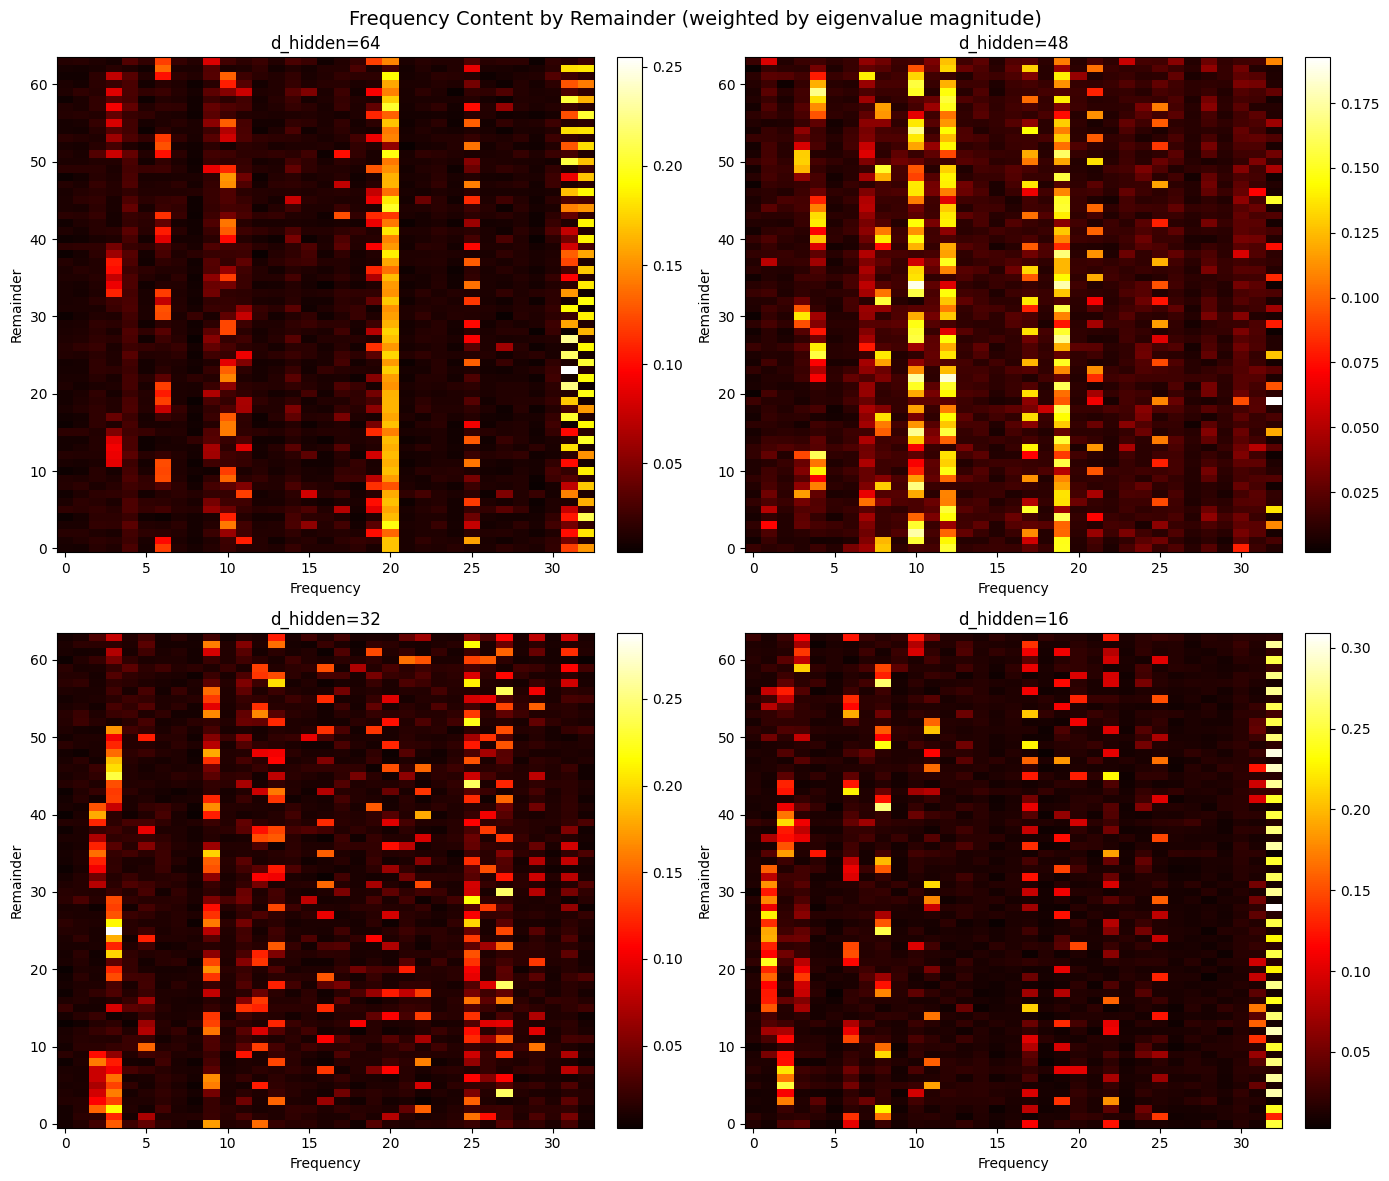

In [11]:
# Plot frequency heatmaps for selected bottleneck sizes
bottleneck_sizes_to_plot = [P, P*3//4, P//2, P//4]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for ax, d_hidden in zip(axes.flat, bottleneck_sizes_to_plot):
    heatmap = compute_frequency_heatmap(eigen_data, d_hidden, P, n_evecs=4)
    im = ax.imshow(heatmap, aspect='auto', cmap='hot', origin='lower')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Remainder')
    ax.set_title(f'd_hidden={d_hidden}')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

fig.suptitle('Frequency Content by Remainder (weighted by eigenvalue magnitude)', fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
# Interactive frequency heatmap explorer
def show_freq_heatmap(d_hidden=P, n_evecs=4):
    heatmap = compute_frequency_heatmap(eigen_data, d_hidden, P, n_evecs)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(heatmap, aspect='auto', cmap='hot', origin='lower')
    ax.set_xlabel('Frequency', fontsize=12)
    ax.set_ylabel('Remainder', fontsize=12)
    ax.set_title(f'Frequency Heatmap (d_hidden={d_hidden}, top {n_evecs} evecs)', fontsize=14)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

d_slider = widgets.IntSlider(min=1, max=P, step=1, value=P, description='d_hidden')
n_slider = widgets.IntSlider(min=1, max=10, step=1, value=4, description='n_evecs')
out = widgets.interactive_output(show_freq_heatmap, {'d_hidden': d_slider, 'n_evecs': n_slider})
display(widgets.HBox([d_slider, n_slider]), out)

Output()

## Dominant Frequencies Analysis

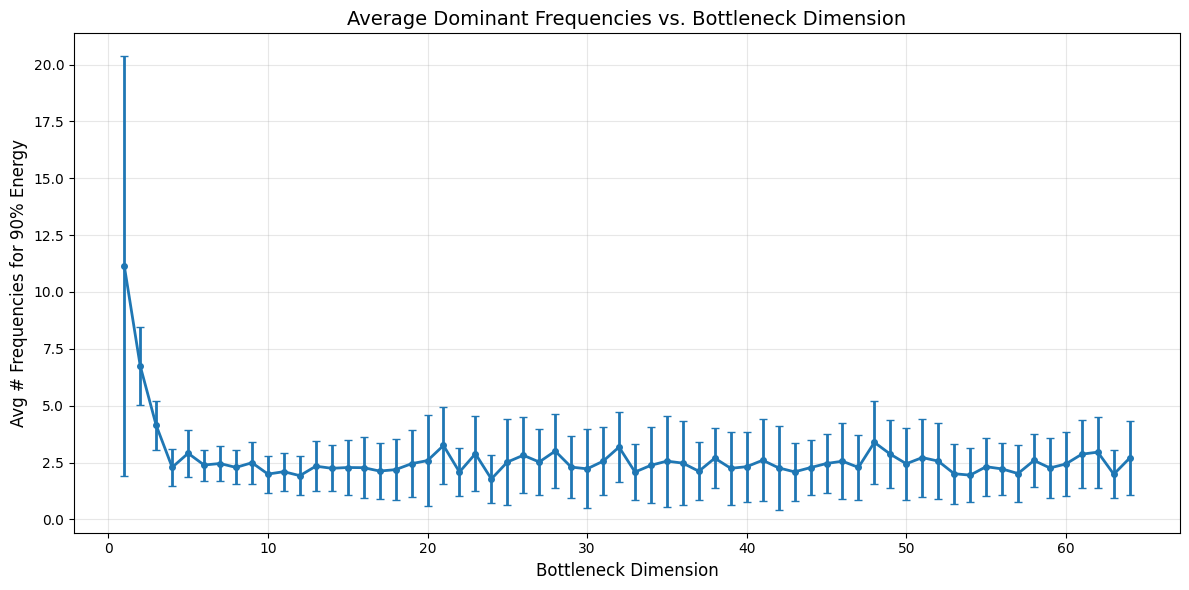

In [13]:
def count_dominant_frequencies(fft_magnitudes, energy_threshold=0.95):
    """Count number of frequencies needed to capture energy_threshold of total FFT energy."""
    energy = fft_magnitudes ** 2
    total_energy = energy.sum()
    if total_energy < 1e-12:
        return 0
    sorted_energy = np.sort(energy)[::-1]
    cumulative = np.cumsum(sorted_energy) / total_energy
    idx = np.searchsorted(cumulative, energy_threshold)
    return min(idx + 1, len(fft_magnitudes))

# Compute average number of dominant frequencies for each bottleneck size
n_top_evecs = 4
freq_threshold = 0.90
avg_dominant_freqs = {}

for d_hidden in range(1, P+1):
    evecs = eigen_data[d_hidden]['eigenvectors']
    
    n_freqs_per_evec = []
    for r in range(P):
        for i in range(min(n_top_evecs, evecs.shape[2])):
            evec = evecs[r, :, i]
            fft_a = np.abs(np.fft.rfft(evec[:P]))
            n_freqs = count_dominant_frequencies(fft_a, freq_threshold)
            n_freqs_per_evec.append(n_freqs)
    
    avg_dominant_freqs[d_hidden] = {
        'mean': np.mean(n_freqs_per_evec),
        'std': np.std(n_freqs_per_evec),
        'median': np.median(n_freqs_per_evec)
    }

# Plot
dims = list(range(1, P+1))
means = [avg_dominant_freqs[d]['mean'] for d in dims]
stds = [avg_dominant_freqs[d]['std'] for d in dims]

fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(dims, means, yerr=stds, fmt='o-', capsize=3, linewidth=2, markersize=4)
ax.set_xlabel('Bottleneck Dimension', fontsize=12)
ax.set_ylabel(f'Avg # Frequencies for {int(freq_threshold*100)}% Energy', fontsize=12)
ax.set_title('Average Dominant Frequencies vs. Bottleneck Dimension', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

Key observations:
- For small bottlenecks, eigenvectors have more dominant frequencies
- Frequency content stabilizes as bottleneck dimension increases
- The interaction matrices show clear frequency patterns (cosine-like structure)